# Normalized Graph Convolutional Neural Network
This notebook shows the training process of a GCN using the KrasHras dataset from [Zamora-Resendiz and Crivelli, 2019](https://www.biorxiv.org/content/10.1101/610444v1.full). This GCN contains two kind of layers: GraphConvolution and NormalizationLayer. The data was subjected to augmentation to balance the classes in the dataset.

In [1]:
import gcn_prot
import torch

import torch.nn.functional as F
from os.path import join, pardir
from sklearn.metrics import confusion_matrix

In [2]:
ROOT_DIR = pardir

## Table of contents

1. [Initialize Data](#Initialize-Data)
2. [Define the neural network](#Define-the-neural-network)
3. [Training loop](#Training-loop)
4. [Validation](#Validation)

## Initialize Data
The data for this experiment is the one used for testing on the [CI of the repository](https://github.com/carrascomj/gcn-prot/blob/master/.travis.yml). Thus, it is already fetched.  

The first step is to calculate the length of the largest protein (in number of aminoacids), since all the proteins will be zero padded to that value. That way, all the inputs fed to the model will have the same length.

In [3]:
largest = gcn_prot.data.get_longest(join(ROOT_DIR, "new_data", "graph"))
print(f"Largest protein has {largest} aminoacids")

Largest protein has 189 aminoacids


However, for this particular dataset, it is known from the aforementioned publication that 185 is enough because the 4 terminal aminoacids were not well determined and would be later discarded by the mask.

In [4]:
largest = 185
data_path = join(ROOT_DIR, "new_data")

The split is performed with 70/10/20 for train/test/valid.  

Note that the generated datasets (custom child classes of `torch.utils.data.Dataset`) do not store in memory the graphs but their paths, **generating the graph on demand when accessed by an index**.

In [5]:
train, valid, test = gcn_prot.data.get_datasets(
    data_path=data_path,
    nb_nodes=largest,
    task_type="classification",
    nb_classes=2,
    split=[0.6, 0.1, 0.3],
    seed=42,
    augment=3,           # data augmentation factor x3
    augmented_label="0", # augmentation will be applied just for label "0"
)

CLASS[COUNTS]:  0 78
CLASS[COUNTS]:  1 158


We can see how the classes are here **imbalanced** in a ~30/70 ratio. This fact explains the reason behind **data augmentation** for label "0".

In [6]:
print(f"Train: {len(train)}\nTest: {len(test)}\nValidation: {len(valid)}")

Train: 221
Test: 127
Validation: 24


Both train and test datasets are subjected to the augmentation. 

In [7]:
type(train)

gcn_prot.data.protien_graph.ProtienGraphDataset

## Define the neural network

Each instance in the dataset retrieves a list of four matrices:
1. **feature matrix**: 29 x 185. This corresponds to the aminoacid type (one-hot encoded vector of length 23), residue depth, residue orientation and 4 features encoding the positional index with a sinusoidal transformation.
2. **coordinates**: 3 x 185. x,y,z coordinates of every aminoacid in the crystal (centered).
3. **mask**: to be applied to the adjacency to discard ill-identified aminoacids.
4. **y**: 2 labels, Kras/Hras.  

The transformation of this list to the input of the neural network (feature matrix, adjacency matrix), is performed during training.

In [8]:
model = gcn_prot.models.GCN_normed(
    feats=29,             # features in feature matrix
    hidden=[30, 20],      # number of neurons in convolutional layers (2 in this case)
    label=2,              # features on y
    nb_nodes=largest,     # for last layer
    dropout=0.,          # applied in the convolutional layers
    bias=False,           # default
    act=F.relu,           # default
    D=1,
    cuda=True             # required for sparsize and fit_network
).cuda()

Now, instantiate the criterion and the optimizer.

In [9]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss().cuda()

## Training loop

In [10]:
%matplotlib inline

Epoch 1 (2/3)            

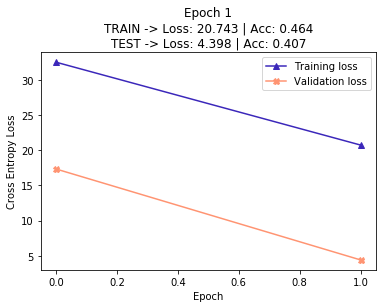

Epoch 2 (2/3)            

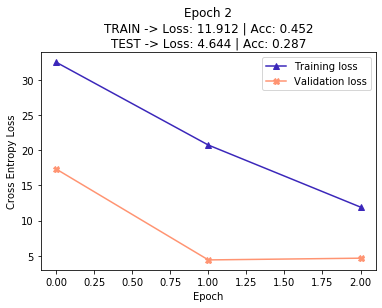

Epoch 3 (2/3)            

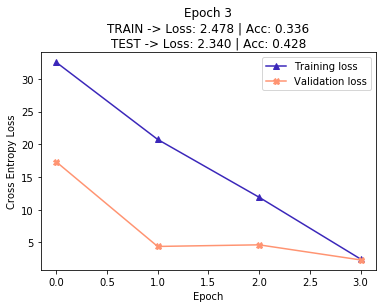

Epoch 4 (2/3)            

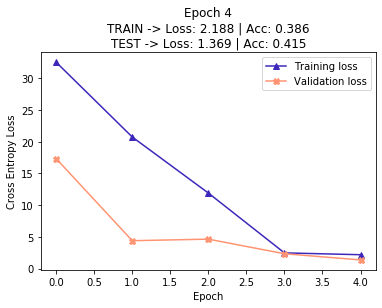

Epoch 5 (0/4)            

In [ ]:
save_path = join(ROOT_DIR, "models", "GCN_tiny_weigths.pt")
model = gcn_prot.models.fit_network(
    model, train, test, optimizer, criterion,
    batch_size=56,
    epochs=16,
    debug=True,      # will print progress of epochs
    plot_every=1,    # loss plot/epoch
    save=save_path   # best weights (test set) will be saved here
)

## Validation

In [ ]:
validator = gcn_prot.models.Validation(model, valid)
validator.validate()
validator.compute_stats()

In [ ]:
from IPython.display import Latex as lt

lt(validator.__str__())

In [ ]:
validator.prediction